In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [5]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)

In [ ]:
file='oil.csv'
df_oil=pd.read_csv(f'{dir}/{file}')


df_oil.date=pd.to_datetime(df_oil.date)
df_oil=df_oil.set_index('date')
df_oil = df_oil.rename(columns={'dcoilwtico': 'oil_price'})

In [4]:
df_oil

,oil_price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [5]:
df_oil_daily = df_oil.asfreq('D')

/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Axes: >

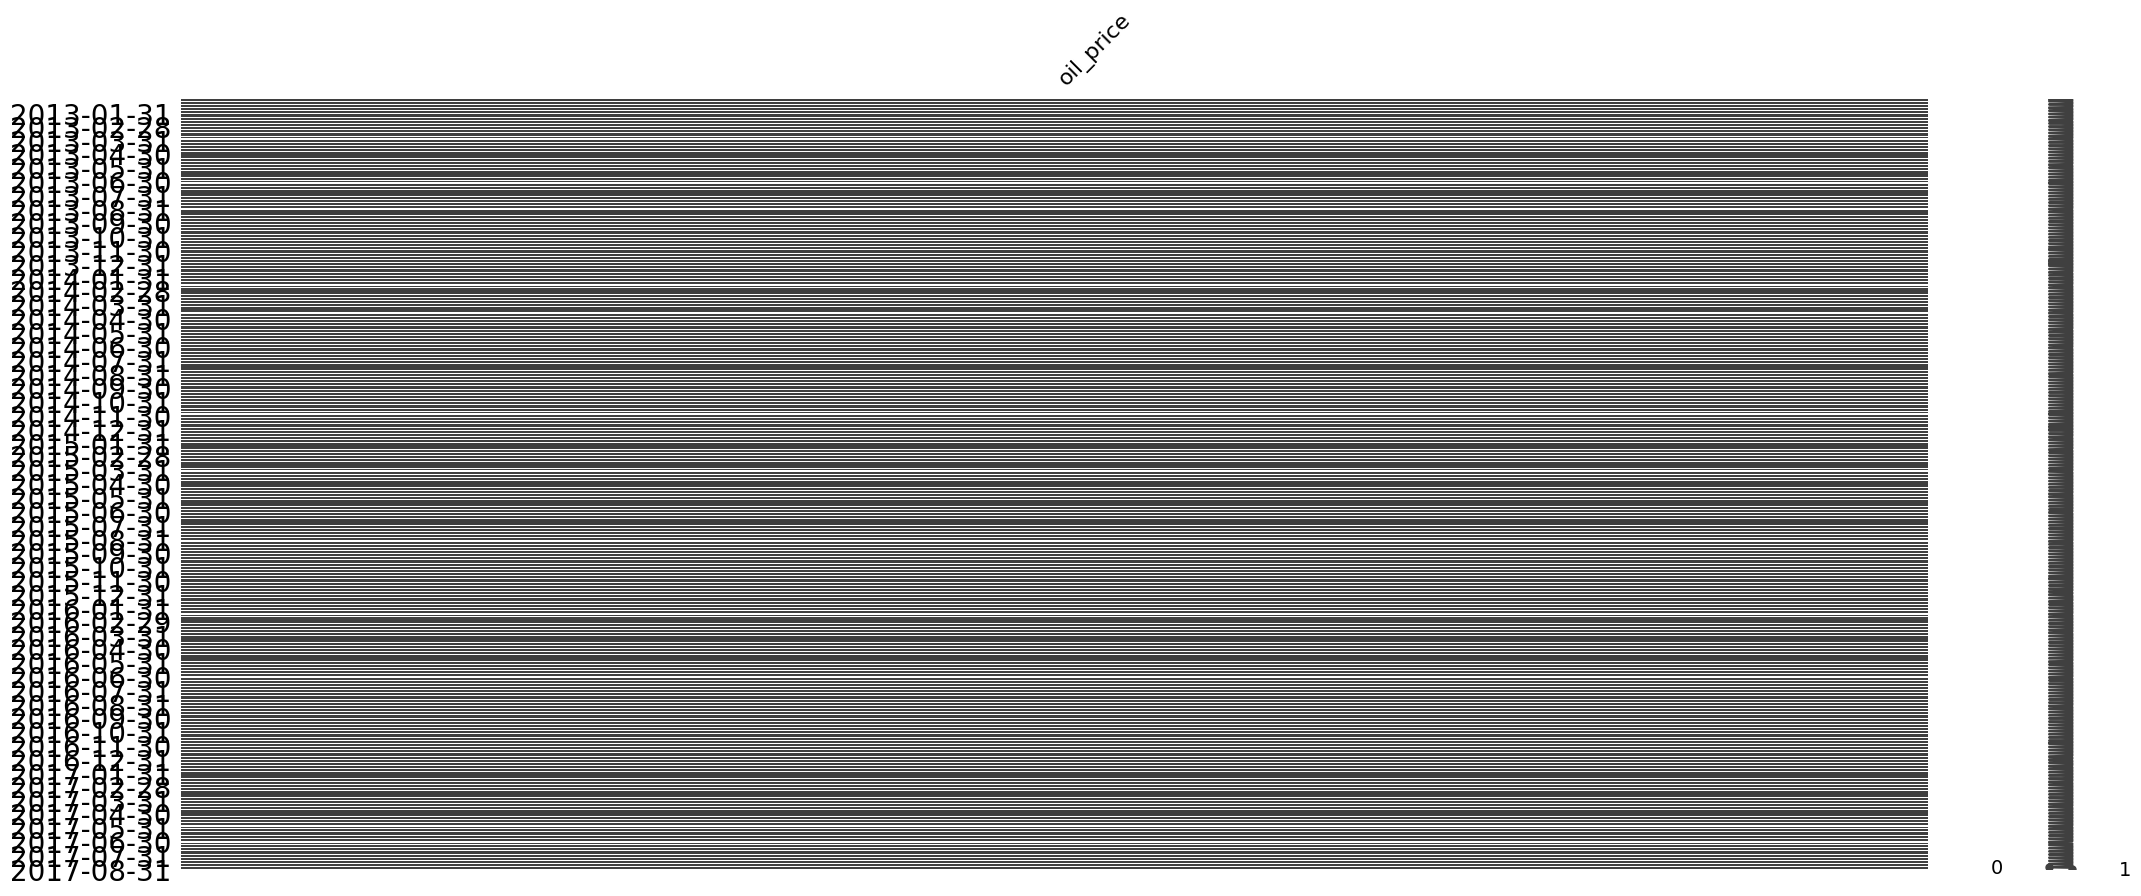

In [6]:
msno.matrix(df_oil_daily[['oil_price']], freq='M')

/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Axes: >

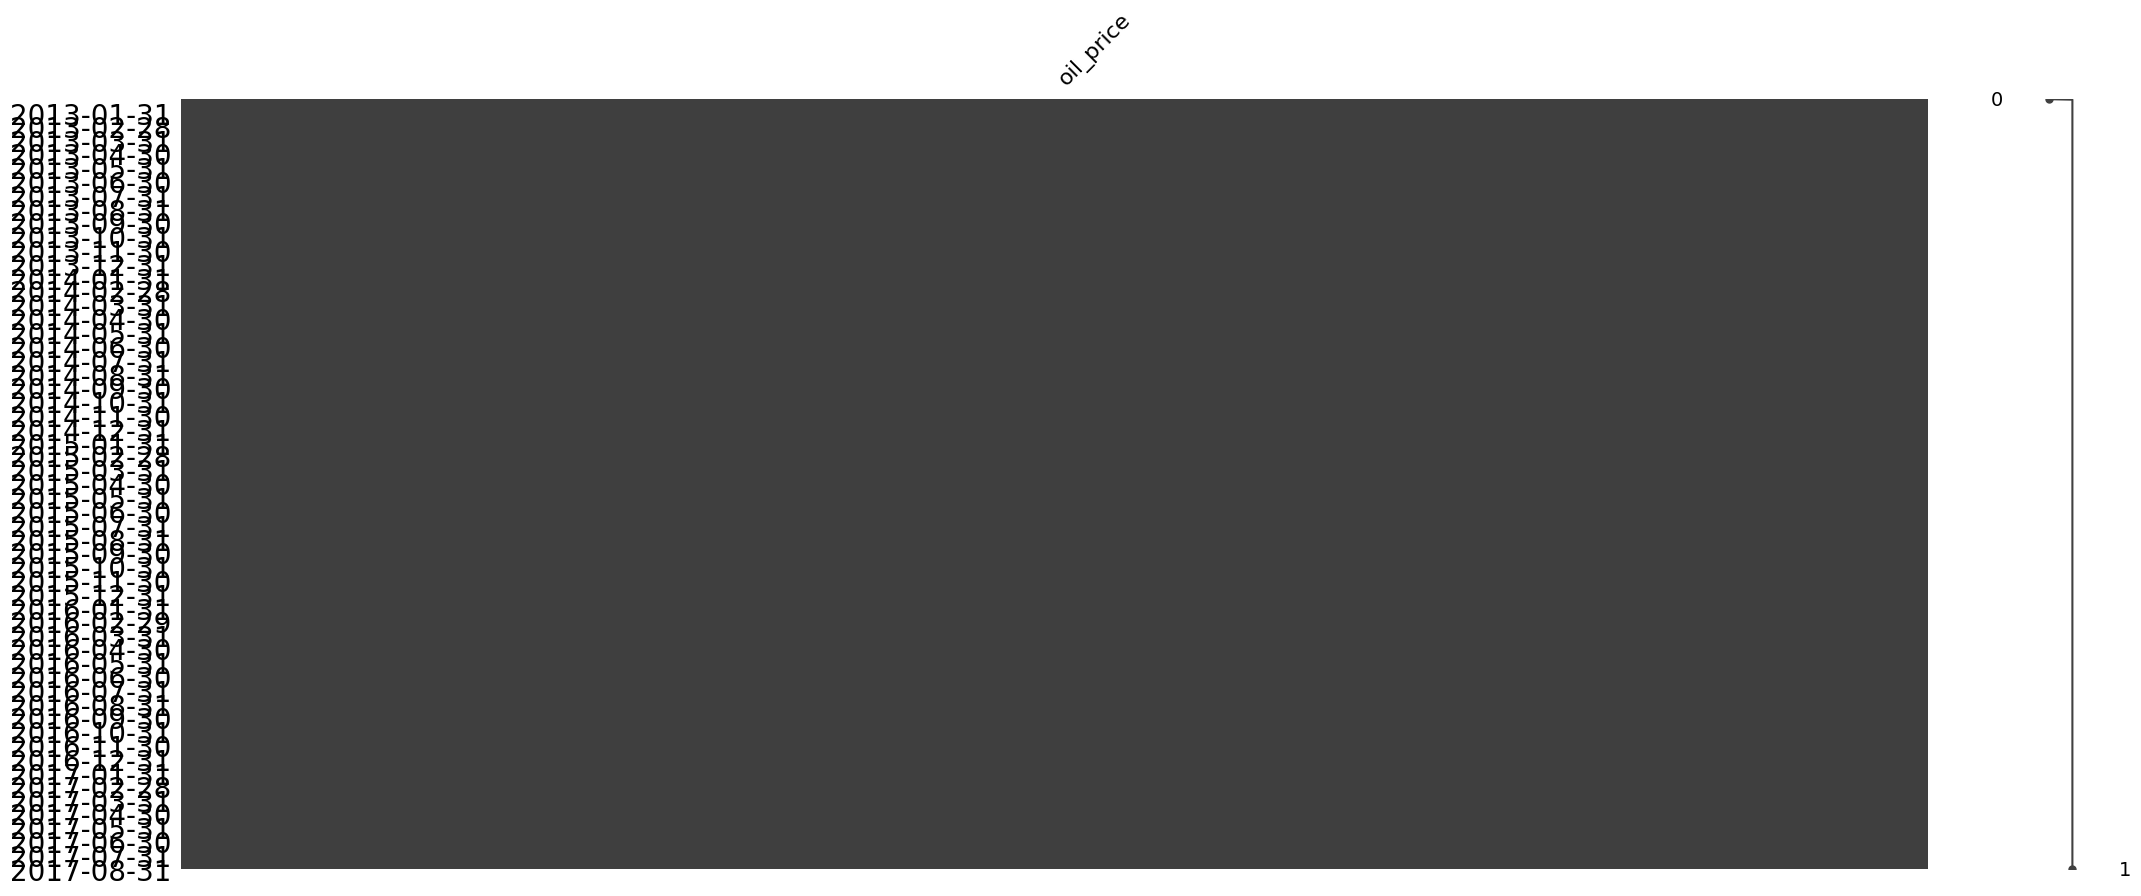

In [7]:
df_oil_daily = df_oil.asfreq('D').ffill()

msno.matrix(df_oil_daily[['oil_price']], freq='M')

/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Axes: >

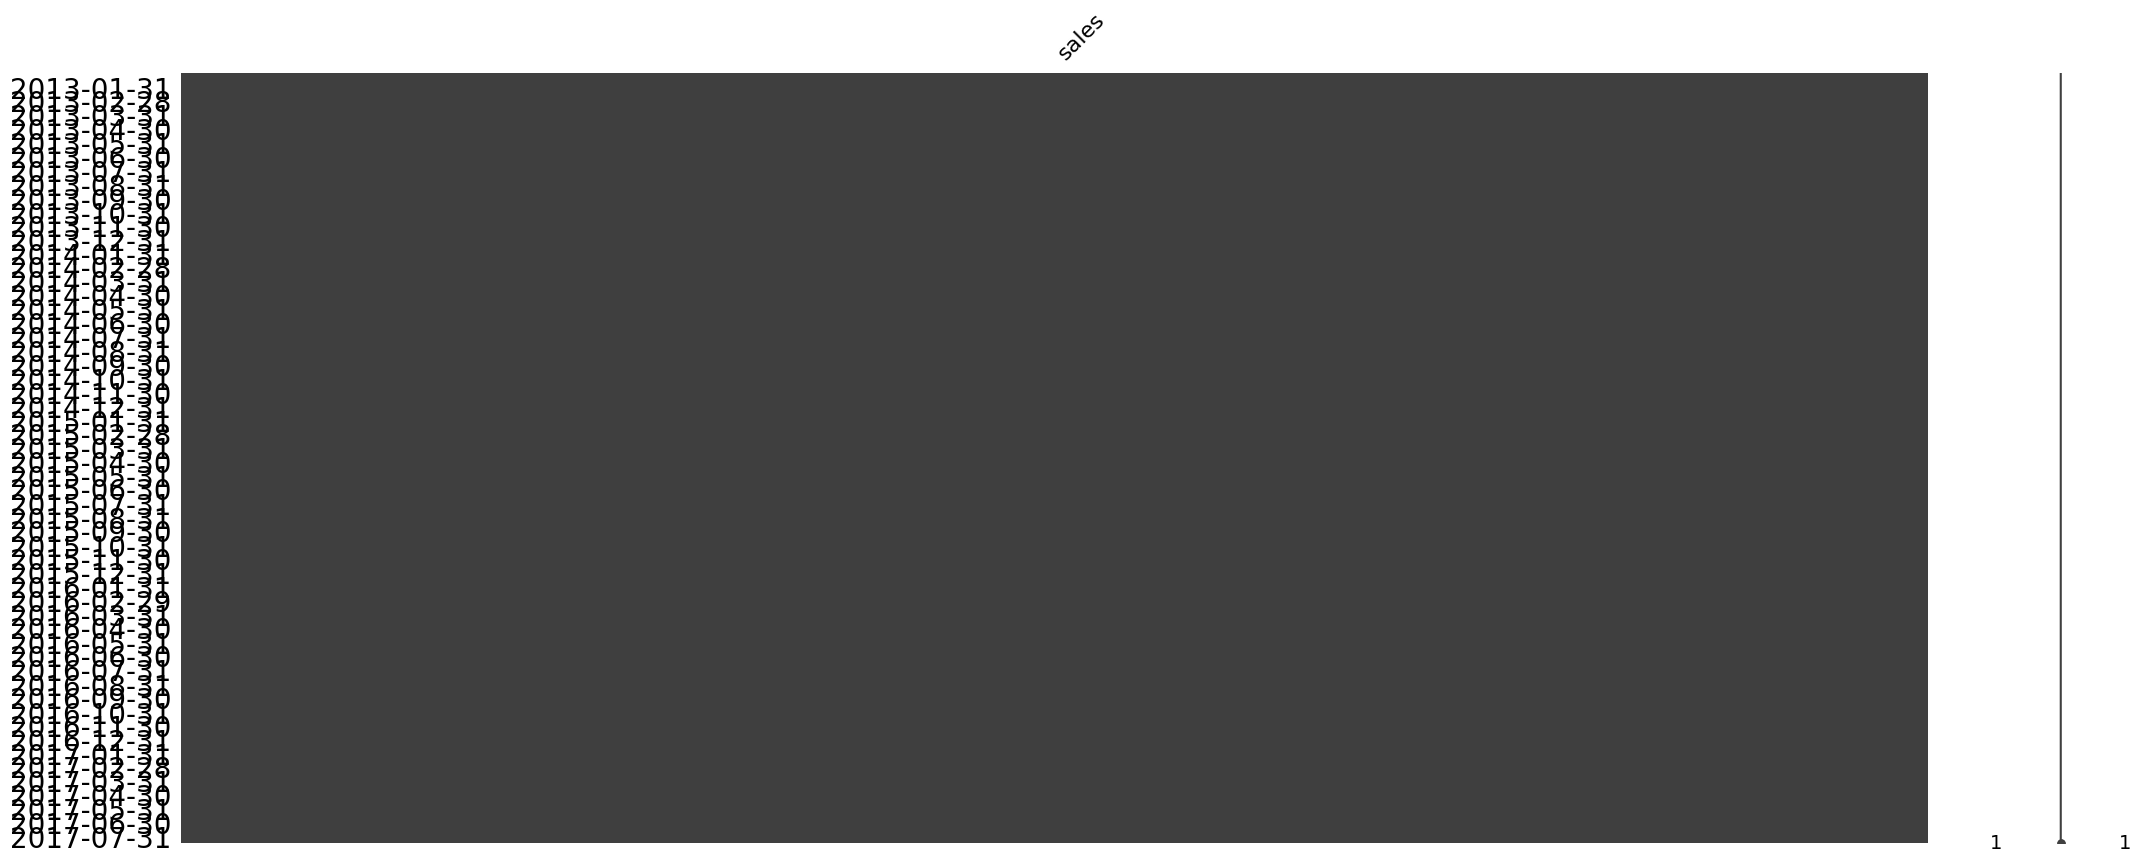

In [6]:
store_nbr=list(df.store_nbr.unique())[0]
df_store_nbr=df[df['store_nbr']==store_nbr]
family=list(df_store_nbr.family.unique())[0]
df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
df_store_nbr_family=df_store_nbr_family.set_index('date')
msno.matrix(df_store_nbr_family[['sales']], freq="M")

Text(0.5, 1.0, 'Store#1: AUTOMOTIVE')

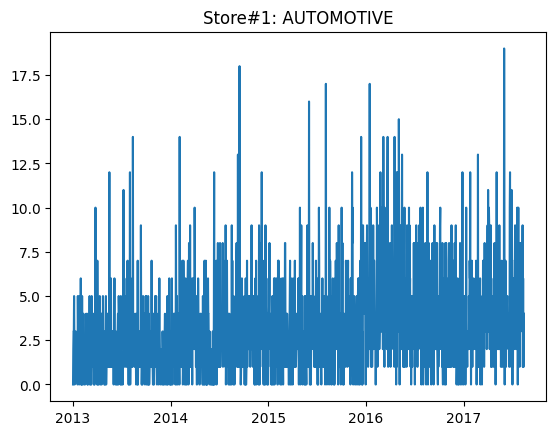

In [9]:
plt.plot(df_store_nbr_family.index,df_store_nbr_family.sales)
plt.title(f'Store#{store_nbr}: {family}')

#### Rolling monthly average

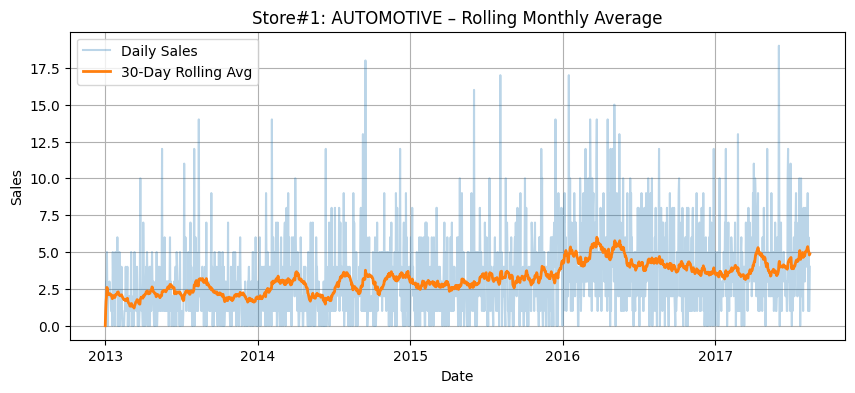

In [10]:
rolling_monthly_avg = df_store_nbr_family['sales'].rolling('30D').mean()

plt.figure(figsize=(10, 4))
plt.plot(df_store_nbr_family.index, df_store_nbr_family.sales, alpha=0.3, label='Daily Sales')
plt.plot(rolling_monthly_avg.index, rolling_monthly_avg, linewidth=2, label='30-Day Rolling Avg')

plt.title(f'Store#{store_nbr}: {family} – Rolling Monthly Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### Aggregate daily sales to monthly sales

In [11]:
monthly_sales = df_store_nbr_family['sales'].resample('M').sum()

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_27201/3125912608.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_store_nbr_family['sales'].resample('M').sum()


#### PLot monthly sales

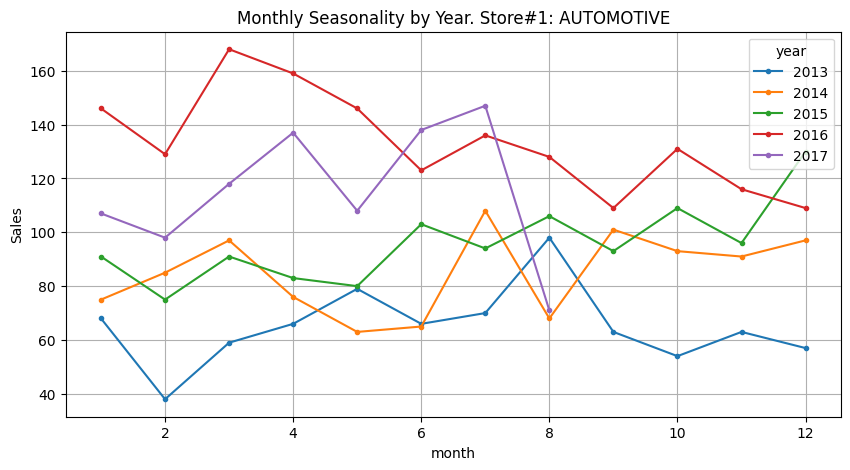

In [12]:
monthly_df = monthly_sales.to_frame('sales')
monthly_df['year'] = monthly_df.index.year
monthly_df['month'] = monthly_df.index.month

pivot = monthly_df.pivot(index='month', columns='year', values='sales')

ax=pivot.plot(figsize=(10, 5),    
           style='.-',
           title=f'Monthly Seasonality by Year. Store#{store_nbr}: {family}')
ax.set_ylabel('Sales')
ax.grid(True)

plt.show()

#### Make stationary

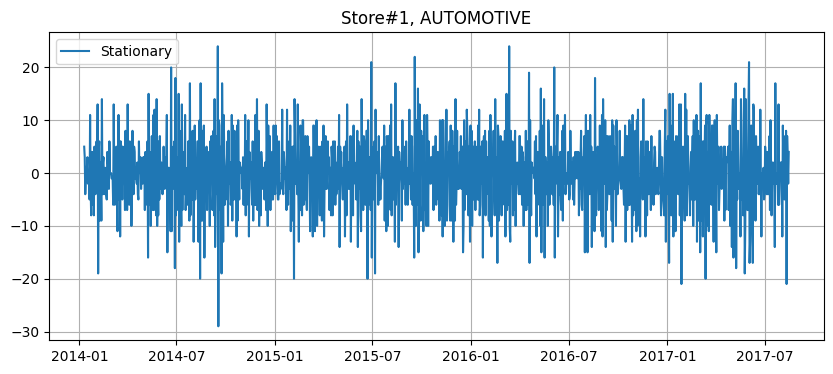

In [48]:
ts = df_store_nbr_family['sales']
# Remove trend
ts_diff1 = ts.diff(1)
# Remove weekly seasonality (lag = 7)
ts_diff1_weekly = ts_diff1.diff(7)
# Remove yearly seasonality (lag = 365)
ts_stationary = ts_diff1_weekly.diff(365)
# Drop missing values 
ts_stationary = ts_stationary.dropna()

ts_aligned = ts.loc[ts_stationary.index]

ts_norm = (ts_aligned - ts_aligned.mean()) / ts_aligned.std()

plt.figure(figsize=(10, 4))
#plt.plot(ts_norm, label=f'Original sales(normalized)')
plt.plot(ts_stationary, label='Stationary')

plt.legend()
plt.grid(True)
plt.title(f'Store#{store_nbr}, {family}')
plt.show()

#### Correlation between oil price and sales

In [18]:
df_merged = df_store_nbr_family[['sales']].join(df_oil, how='inner')

In [22]:
df_merged['oil_price'] = df_merged['oil_price'].ffill()

In [26]:
corr = df_merged['sales'].corr(df_merged['oil_price'])
corr

-0.25724013582994965

In [27]:
corr_spearman = df_merged['sales'].corr(df_merged['oil_price'], method='spearman')
corr_spearman

-0.2681911531179426

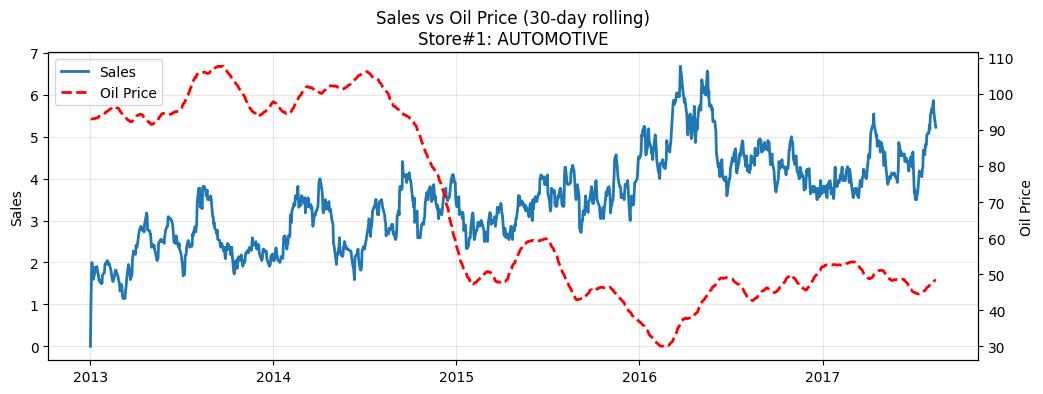

In [31]:
df_plot = df_merged.copy()

df_plot['sales_smooth'] = df_plot['sales'].rolling('30D').mean()
df_plot['oil_smooth'] = df_plot['oil_price'].rolling('30D').mean()


fig, ax1 = plt.subplots(figsize=(12, 4))

# Sales (left axis)
ax1.plot(
    df_plot.index,
    df_plot['sales_smooth'],
    label='Sales',
    linewidth=2
)
ax1.set_ylabel('Sales')
ax1.grid(True, alpha=0.3)

# Oil price (right axis)
ax2 = ax1.twinx()
ax2.plot(
    df_plot.index,
    df_plot['oil_smooth'],
    linestyle='--',
    label='Oil Price',
    color='red',
    linewidth=2
)
ax2.set_ylabel('Oil Price')

# Title
plt.title(f'Sales vs Oil Price (30-day rolling)\nStore#{store_nbr}: {family}')

# Legend (combine both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

In [29]:
for lag in [1, 7, 14, 30]:
    corr = df_merged['sales'].corr(df_merged['oil_price'].shift(lag))
    print(f"Lag {lag} days: {corr:.3f}")

Lag 1 days: -0.258
Lag 7 days: -0.260
Lag 14 days: -0.262
Lag 30 days: -0.260
